# Polynômes de chaos : application au cas de la poutre encastrée avec chaos par moindres carrés

## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment calculer les coefficients par moindres carrés. Le but de cet exemple est d'utiliser des fonctionnalités de plus bas niveau que celles disponibles dans la classe `FunctionalChaosAlgorithm`. Cet exemple est le complément de `Exercice-chaos-cantilever-beam-Integration.ipynb`, où nous calculons les coefficients par intégration.

TODO : 
- Estimation par moindres carrés _"all-subsets"_.
- Estimation par moindres carrés régularisés _"ridge"_.
- Estimation par moindres carrés LARS.
- méthode _"stepwise_".

## References

- On the Markdown format : https://github.com/openturns/openturns/pull/2415
- On the use of the linear model for a polynomial chaos expansion : https://github.com/openturns/openturns/pull/2373

## Introduction

Considèrons un modèle physique $g : \mathbb{R}^p \rightarrow \mathbb{R}$ :
$$
Y = g(\boldsymbol{X})
$$
où $\boldsymbol{X} \in \mathcal{X} \subseteq \mathbb{R}^p$ est un vecteur aléatoire et $Y\in \mathbb{R}$ est une variable aléatoire. 
On considère la transformation $\boldsymbol{Z} = T(\boldsymbol{X})$, où $\boldsymbol{X} \in \mathbb{R}^p$ est le vecteur aléatoire en entrée du modèle physique, $T$ est la transformation iso-probabiliste et $\boldsymbol{Z} \in \mathcal{Z} \subseteq \mathbb{R}^p$ est la variable standardisée. 
On introduit la fonction $h$ définie par :
$$
h(\boldsymbol{Z}) = g\left(T^{-1}(\boldsymbol{Z})\right) = (g \circ T^{-1}) (\boldsymbol{Z})
$$
pour tout $\boldsymbol{Z}\in \mathcal{Z}$. 

La décomposition en polynômes du chaos est :
$$
\widetilde{h}(\boldsymbol{Z}) = \sum_{k = 0}^P a_k \Psi_k(\boldsymbol{Z})
$$
pour tout $\boldsymbol{Z}\in \mathcal{Z}$, où $P \in \mathbb{N}$ est le nombre de coefficients dans la décomposition, $a_k \in \mathbb{R}$ est le coefficient, $\psi_k$ est le polynôme multivarié et $\boldsymbol{Z}$ est la variable standardisée. 


### Calcul des coefficients par moindres carrés

Soit $n \in \mathbb{N}$ un entier représentant la taille de l'échantillon. Soit $\left\{\boldsymbol{x}^{(j)}\right\}_{j = 1, ..., n}$ un échantillon i.i.d. du vecteur aléatoire $\boldsymbol{X}$. Soit $\left\{y^{(j)} = g\left(\boldsymbol{x}^{(j)}\right)\right\}$ l'échantillon correspondant les valeurs du modèle physique. Soit $\boldsymbol{y} \in \mathbb{R}^n$ le vecteur des observations en sortie du modèle physique :
$$
\boldsymbol{y} = \left(y^{(1)}, ..., y^{(n)}\right) \in \mathbb{R}^n.
$$
Soit $\left\{\boldsymbol{z}^{(j)}\right\}$ l'échantillon des entrées observées standardisées :
$$
\boldsymbol{z}^{(j)} = T\left(\boldsymbol{x}^{(j)}\right)
$$
pour $j = 1, ..., n$
On considère la matrice de conception $D \in \mathbb{R}^{n(P + 1)}$ définie par :
$$
d_{jk} = \psi_k\left(\boldsymbol{z}^{(j)}\right)
$$
pour $j = 1, ..., n$ et $k = 1, ..., P + 1$.
Le vecteur des coefficients du chaos polynomial est :
$$
\boldsymbol{a} = (a_0, a_1, ..., a_P)\in \mathbb{R}^{P + 1}.
$$
Les prédictions du modèle sont :
$$
\widehat{\boldsymbol{y}} = D \boldsymbol{a}
$$
La méthode des moindres carrés consiste à rechercher la solution du problème :
$$
\widehat{\boldsymbol{a}} = \operatorname{argmin}_{\boldsymbol{a} \in \mathbb{R}^{P + 1}} \left\|\boldsymbol{y} - D \boldsymbol{a}\right\|_2
$$

In [3]:
from openturns.usecases import ishigami_function
import openturns as ot
import openturns.viewer as otv
from IPython.display import Markdown

In [4]:
ot.Log.Show(ot.Log.NONE)
ot.RandomGenerator.SetSeed(0)

Dans la cellule suivante, nous créons le modèle physique associé à la fonction d'Ishigami et nous générons un échantillon d'apprentissage.

In [5]:
im = ishigami_function.IshigamiModel()
sampleSize = 1000
inputTrainSample = im.distributionX.getSample(sampleSize)
outputTrainSample = im.model(inputTrainSample)

Dans la cellule suivante, nous créons la base de polynômes orthogonaux associés à la loi de distribution jointe du vecteur aléatoire en entrée du modèle physique.

In [6]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory([im.X1, im.X2, im.X3])
totalDegree = 4
enumerateFunction = multivariateBasis.getEnumerateFunction()
basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)
print("Basis size = ", basisSize)

Basis size =  35


Dans la cellule suivante, nous créons la base de fonctions.

In [7]:
standardizedDistribution = multivariateBasis.getMeasure()
transformation = ot.DistributionTransformation(
    im.distributionX, standardizedDistribution
)
standardInputTrainSample = transformation(inputTrainSample)
# Create the basis
basis = ot.Basis()
for i in range(basisSize):
    basisFunction = multivariateBasis.build(i)
    basis.add(basisFunction)

Pour évaluer les coefficients, nous utilisons la classe `LinearModelAlgorithm`. Il est important de considérer non pas l'échantillon de la variable physique d'entrée, mais l'échantillon de la variable d'entrée standardisée.

In [8]:
lma = ot.LinearModelAlgorithm(standardInputTrainSample, outputTrainSample, basis)
lma.run()
lmResult = lma.getResult()
metamodel = lmResult.getMetaModel()

Dans la cellule suivante, nous validons le métamodèle de chaos polynomial.

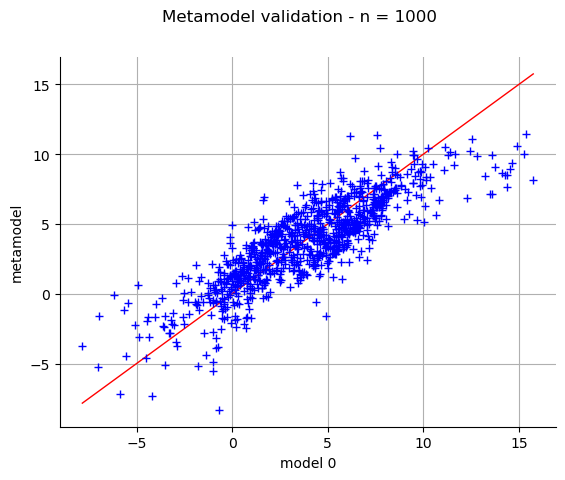

In [9]:
inputTestSample = im.distributionX.getSample(sampleSize)
outputTestSample = im.model(inputTestSample)
standardInputTestSample = transformation(inputTestSample)
val = ot.MetaModelValidation(standardInputTestSample, outputTestSample, metamodel)
graph = val.drawValidation()
view = otv.View(graph)

Nous pouvons ensuite récupérer les coefficients de la décomposition.

In [10]:
coefficients = lmResult.getCoefficients()
coefficients

class=Point name=Unnamed dimension=35 values=[3.43797,1.58824,-0.0746952,-0.117765,0.0547603,0.090274,-0.024324,-0.522636,0.0557932,-0.0667344,-1.22986,0.0361724,-0.034229,0.0235648,0.0256867,1.43314,-0.00632906,-0.0185813,-0.105488,-0.180489,0.0824164,-0.0425435,-0.0782013,-0.10975,-0.0787552,0.130931,0.0578816,-0.0203553,0.0541069,0.0824176,-1.95768,0.0230745,0.158188,-0.0428948,-0.0992381]

Pour afficher les coefficients, nous utilisons le format Markdown.

In [11]:
markdown = ""
# Table
markdown += "| Index | Multi-Index | Coefficients |\n"
markdown += "|-------|-------------|--------------|\n"
for k in range(basisSize):
    multiIndex = enumerateFunction(k)
    markdown += f"| {k} | {multiIndex} | {coefficients[k]} |\n"
markdown += "\n"
Markdown(markdown)

| Index | Multi-Index | Coefficients |
|-------|-------------|--------------|
| 0 | [0,0,0] | 3.4379668162712766 |
| 1 | [1,0,0] | 1.5882399793397814 |
| 2 | [0,1,0] | -0.07469522716214433 |
| 3 | [0,0,1] | -0.11776474404676689 |
| 4 | [2,0,0] | 0.05476028669798244 |
| 5 | [1,1,0] | 0.09027402803739555 |
| 6 | [1,0,1] | -0.02432398526741499 |
| 7 | [0,2,0] | -0.5226359666773004 |
| 8 | [0,1,1] | 0.05579322537178066 |
| 9 | [0,0,2] | -0.06673438809418039 |
| 10 | [3,0,0] | -1.2298590018949096 |
| 11 | [2,1,0] | 0.03617242095414071 |
| 12 | [2,0,1] | -0.03422902396632959 |
| 13 | [1,2,0] | 0.02356481292208637 |
| 14 | [1,1,1] | 0.025686700077268223 |
| 15 | [1,0,2] | 1.4331438344388856 |
| 16 | [0,3,0] | -0.006329056513434299 |
| 17 | [0,2,1] | -0.01858132287062612 |
| 18 | [0,1,2] | -0.10548841405719664 |
| 19 | [0,0,3] | -0.18048885996937236 |
| 20 | [4,0,0] | 0.08241643308157866 |
| 21 | [3,1,0] | -0.04254353333980015 |
| 22 | [3,0,1] | -0.0782013309242648 |
| 23 | [2,2,0] | -0.10974994435750024 |
| 24 | [2,1,1] | -0.07875521149282215 |
| 25 | [2,0,2] | 0.13093086445335086 |
| 26 | [1,3,0] | 0.05788158149964978 |
| 27 | [1,2,1] | -0.020355342888160738 |
| 28 | [1,1,2] | 0.05410687471562454 |
| 29 | [1,0,3] | 0.08241755810305233 |
| 30 | [0,4,0] | -1.9576760903906643 |
| 31 | [0,3,1] | 0.023074523246829612 |
| 32 | [0,2,2] | 0.15818770782838484 |
| 33 | [0,1,3] | -0.0428948110203287 |
| 34 | [0,0,4] | -0.09923812915049098 |



Dans la cellule suivante, nous affichons la valeur absolue de chaque coefficient en fonction du degré total du multi-indice correspondant.

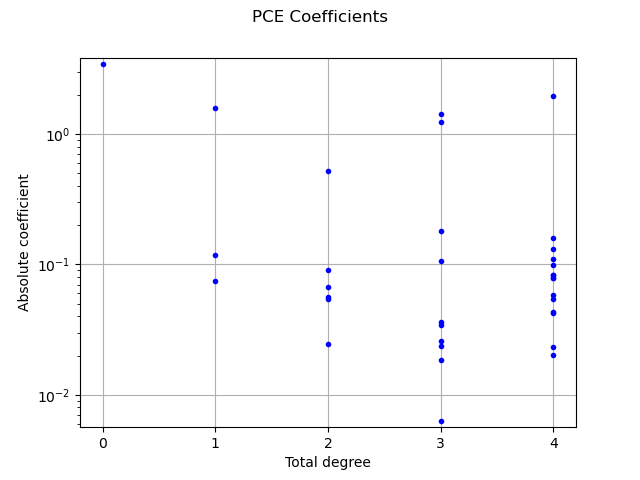

In [12]:
data = ot.Sample(0, 2)
for k in range(basisSize):
    multiIndex = enumerateFunction(k)
    totalDegree = sum(multiIndex)
    data.add([totalDegree, abs(coefficients[k])])
graph = ot.Graph("PCE Coefficients", "Total degree", "Absolute coefficient", True)
cloud = ot.Cloud(data)
cloud.setPointStyle("bullet")
graph.add(cloud)
graph.setLogScale(ot.GraphImplementation.LOGY)
graph.setIntegerXTick(True)
graph

## Exercice 1 : Application à la poutre encastrée

_Questions_
- Changer le modèle et considérer le modèle de poutre encastrée.
- Pour un degré total donné, utiliser la méthode de validation simple et estimer le score $Q^2$. Représenter le $Q^2$ en fonction du degré : qu'observez-vous ?